In [1]:
#!pip install nltk
#!pip install wordcloud
#!pip install xgboost

In [2]:
#nltk.download("stopwords")
#nltk.download('punkt')
#nltk.download('wordnet')

In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#features
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#models
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier

#metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# 1. Data Cleaning

### 1.1 Load data and have an overview
Notice that 'sentiment' column within Canadian_elections_2021.csv has string values 'negative' or 'positive' as the target values. To be consistent with the numerical target values in sentiment_analysis.csv, we transfer 'positive' sentiment = 1 and 'negative' sentiment = 0.

In [4]:
sentiment_df = pd.read_csv('sentiment_analysis.csv')
sentiment_df.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


In [5]:
# check the column types and null values of sentiment_analysis.csv.
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550391 entries, 0 to 550390
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      550391 non-null  float64
 1   text    550391 non-null  object 
 2   label   550391 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 12.6+ MB


In [6]:
elections_df = pd.read_csv('Canadian_elections_2021.csv')
elections_df.head()

,text,sentiment,negative_reason
0,The Canadian election is a power grab by PM Tr...,negative,calling election early
1,I do hope Trudeau loses the Canadian election ...,negative,covid
2,"Dear Canadians, This election is a test of how...",positive,NaN
3,Canadian friends: Never forget that Trudeau ha...,negative,calling election early
4,Sorry @theJagmeetSingh I have voted #NDP all m...,positive,NaN


In [7]:
# we will make the target values in Canadian_elections_2021.csv have the same type as int64 in sentiment_analysis.csv.

elections_df['label'] = (elections_df['sentiment'] =="positive").astype(int)
elections_df.drop(['sentiment'], axis =1, inplace=True)
elections_df

,text,negative_reason,label
0,The Canadian election is a power grab by PM Tr...,calling election early,0
1,I do hope Trudeau loses the Canadian election ...,covid,0
2,"Dear Canadians, This election is a test of how...",NaN,1
3,Canadian friends: Never forget that Trudeau ha...,calling election early,0
4,Sorry @theJagmeetSingh I have voted #NDP all m...,NaN,1
...,...,...,...
997,This is absolutely horrible in Canada. The for...,others,0
998,@davidakin Trudeau imposes gun control policie...,gun control,0
999,In Canada 🇨🇦 our election is being stolen by t...,others,0
1000,"O'Toole amends platform on gun control, but qu...",tell lies,0


In [8]:
# check the column types and null values of Canadian_elections_2021.csv.
elections_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             1002 non-null   object
 1   negative_reason  387 non-null    object
 2   label            1002 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


### 1.2 Clean Data
We clean the data through following steps in order and use the same pipeline for both datasets.
- All html tags and attributes (i.e., /<[^>]+>/) are removed.
- Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
- All URLs are removed.
- All characters in the text are in lowercase.
- All stop words are removed. (We use those stop words that are already defined in nltk library.)
     
 (If a tweet is empty after pre-processing, it would be preserved as such.)

In [9]:
# all html tags and attributes are removed
import re

TAG_RE = re.compile(r'<[^>]+>')

def remove_html(text):
    return TAG_RE.sub('', text)

sentiment_df['text']=sentiment_df['text'].apply(remove_html)
elections_df['text']=elections_df['text'].apply(remove_html)

In [10]:
# html character codes are replaced with ASCII
import html
def replace_html(text):
    text = html.unescape(text)
    return text
    
sentiment_df['text']=sentiment_df['text'].apply(replace_html)
elections_df['text']=elections_df['text'].apply(replace_html)

In [11]:
# all URLs are removed
def remove_url(text):
    return re.sub('http\S+|www\S+|https\S+','', text)
    
sentiment_df['text']=sentiment_df['text'].apply(remove_url)
elections_df['text']=elections_df['text'].apply(remove_url)

In [12]:
# all characters in the text are in lowercase
def lowercase(text):
    text = text.lower()
    return text

sentiment_df['text']=sentiment_df['text'].apply(lowercase)
elections_df['text']=elections_df['text'].apply(lowercase)

In [13]:
# tokenize the string and remove stopwords
from nltk.tokenize import RegexpTokenizer

def token_stop(text):
    tokenizer = RegexpTokenizer(pattern='\w+')
    text = tokenizer.tokenize(text)
    stop = stopwords.words('english')
    stop.append('rt')
    #stop.append('https')
    
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(x) for x in text if not x in stop]       
    
    text = ' '.join(text)
    #words = filter(lambda x: (x not in stop) and (x not in ['rt','https']), text)
    #text = ' '.join(list(words))
    return text

sentiment_df['text']=sentiment_df['text'].apply(token_stop)
elections_df['text']=elections_df['text'].apply(token_stop)

In [14]:
elections_df['text'].head()

0    canadian election power grab pm trudeau yes ta...
1    hope trudeau loses canadian election tomorrow ...
2    dear canadian election test progressive whethe...
3    canadian friend never forget trudeau 2 year ma...
4    sorry thejagmeetsingh voted ndp life election ...
Name: text, dtype: object

# 2. Exploratory Analysis

### 2.1. Determine political party
1) Liberal: Justin Trudeau, Ad:"Relentless".
 - relevant words: liberal, relentless, justintrudeau, trudeau, justin

2) Conservative: Erin O’Toole.
- relevant words: conservative, toole, otoole, erin, cpc

3) New Democratic Party (NDP): Jagmeet Singh. 
- relevant words: NDP, newdemocratic, democratic, jagmeetsingh, jagmeet, singh

4) People's Party of Canada (PPC): Maxime Bernier.
- relevant words: PPC, peoplespca, maximebernier, bernier, maxime

Reference:
https://www.theglobeandmail.com/politics/article-canada-federal-election-20210-party-plaform-guide/

**We label each tweet text in Canadian Elections dataset by determining its related political parties using key words indicated above. Notice that each tweet may be labeled with more than one parties because the tweet can support/criticize multiple election parties. But later we will use the party that is mentioned with the highest frequencies as the label.**  

**We create four extra columns in original dataset and each column represents one political party. If the tweet is classified as certain party, then the corresponding column will have value = True for that row.**

In [20]:
# create four extra columns liberal, conservative, NDP, PPC
# tag True if the tweet with relevant key words belongs to the particular party
elections_df['liberal']=elections_df['text'].str.contains('liberal|relentless|justintrudeau|trudeau|justin')
elections_df['conservative']=elections_df['text'].str.contains('conservative|toole|otoole|trudeau|erin|cpc')
elections_df['NDP']=elections_df['text'].str.contains('ndp|newdemocratic|democratic|jagmeetsingh|jagmeet|singh')
elections_df['PPC']=elections_df['text'].str.contains('ppc|peoplespca|maximebernier|bernier|maxime')
elections_df

,text,negative_reason,label,liberal,conservative,NDP,PPC
0,canadian election power grab pm trudeau yes ta...,calling election early,0,True,True,False,False
1,hope trudeau loses canadian election tomorrow ...,covid,0,True,True,False,False
2,dear canadian election test progressive whethe...,NaN,1,False,False,False,False
3,canadian friend never forget trudeau 2 year ma...,calling election early,0,True,True,False,False
4,sorry thejagmeetsingh voted ndp life election ...,NaN,1,False,False,True,True
...,...,...,...,...,...,...,...
997,absolutely horrible canada forthcoming electio...,others,0,False,False,False,False
998,davidakin trudeau imposes gun control policy u...,gun control,0,True,True,False,False
999,canada election stolen thug uneducated goon de...,others,0,False,False,False,False
1000,toole amends platform gun control question rem...,tell lies,0,False,True,False,False


### 2.2 Distribution of political parties
Count and visualize the number of tweets belong to each party in Canadian Elections dataset.   
We could say that the political affiliations of the tweets among four parties is unevenly distributed, definitely not a normal distribution. Liberal and conservative parties have the highest number of samples, while the PPC has only 14 tweets.

In [21]:
# count number of tweets belong to each party and summarize in a table
parties_name = ['liberal','conservative','NDP','PPC']
parties_count = []
parties_count.append(len(elections_df[elections_df['liberal']==True]))
parties_count.append(len(elections_df[elections_df['conservative']==True]))
parties_count.append(len(elections_df[elections_df['NDP']==True]))
parties_count.append(len(elections_df[elections_df['PPC']==True]))
#parties_count.append(len(elections_df[elections_df['greens']==True]))

parties_df = pd.DataFrame({'Party': parties_name, 'Count': parties_count},index=parties_name)
parties_df.drop(['Party'],axis=1,inplace=True)
parties_df

,Count
liberal,482
conservative,666
NDP,87
PPC,111


Text(0.5, 0, 'Political Parties')

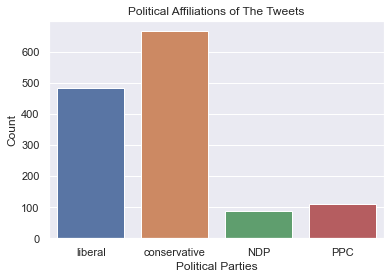

In [22]:
# visualize the political affiliations of the tweets in Canadian Elections dataset
sns.set()
sns.barplot(x=parties_name, y=parties_df.Count)
plt.title('Political Affiliations of The Tweets')
plt.xlabel('Political Parties')

### 2.3 Graphic figure of Canadian Election tweets

In [23]:
# count number of positive and negative sentiments within each party and summarize in a table
positive=[]
negative=[]
positive.append(len(elections_df[(elections_df['liberal']==True) & (elections_df['label']==1)]))
negative.append(len(elections_df[elections_df['liberal']==True]) - positive[0])

positive.append(len(elections_df[(elections_df['conservative']==True) & (elections_df['label']==1)]))
negative.append(len(elections_df[elections_df['conservative']==True]) - positive[1])

positive.append(len(elections_df[(elections_df['NDP']==True) & (elections_df['label']==1)]))
negative.append(len(elections_df[elections_df['NDP']==True]) - positive[2])

positive.append(len(elections_df[(elections_df['PPC']==True) & (elections_df['label']==1)]))
negative.append(len(elections_df[elections_df['PPC']==True]) - positive[3])

#positive.append(len(elections_df[(elections_df['greens']==True) & (elections_df['label']==1)]))
#negative.append(len(elections_df[elections_df['greens']==True]) - positive[4])

print('positive sentiment:',positive)
print('negative sentiment:',negative)

positive = pd.DataFrame(positive,index=parties_name,columns=['positive'])
negative = pd.DataFrame(negative,index=parties_name,columns=['negative'])
party_sentiment = pd.concat([parties_df,positive,negative],axis=1)
party_sentiment

positive sentiment: [269, 374, 66, 85]
negative sentiment: [213, 292, 21, 26]


,Count,positive,negative
liberal,482,269,213
conservative,666,374,292
NDP,87,66,21
PPC,111,85,26


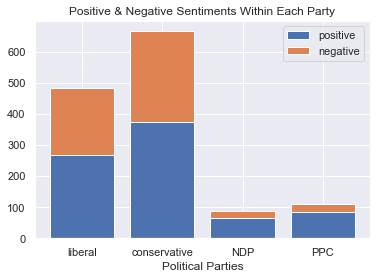

In [24]:
# 2) visualize number of positive and negative sentiments within each party
ax = plt.subplot()
ax.bar(parties_name, party_sentiment.positive, tick_label=parties_name, label='positive')
ax.bar(parties_name, party_sentiment.negative, bottom=party_sentiment.positive, label='negative')
plt.legend()
plt.title('Positive & Negative Sentiments Within Each Party')
plt.xlabel('Political Parties')
plt.show()

**Overall We observed that most of the tweets are affiliated to conservative and liberal parties. Conservative has the highest number of tweets about 666, and liberal has the second highest number of tweets about 482. Both of these two parties have around 55% positive-sentiment and 45% negative-sentiment tweets. Thus, those two political parties are more controversial. Though NDP and PPC parties have less number of tweets related, their proportion of negative sentiment is also much lower, around 24% negative tweets. Overall, there're about 59% tweets having positive sentiments and 41% having negative sentiments; we could say that sentiments are distributed relatively evenly.**

### 2.4 Graphic figure of Generic tweets

In [25]:
# pick the positive sentiment tweets and plot a wordcloud
pos_text = []
for i in sentiment_df[sentiment_df.label==1].text:
    pos_text.append(i)

pos_text = pd.Series(pos_text).str.cat(sep=' ')

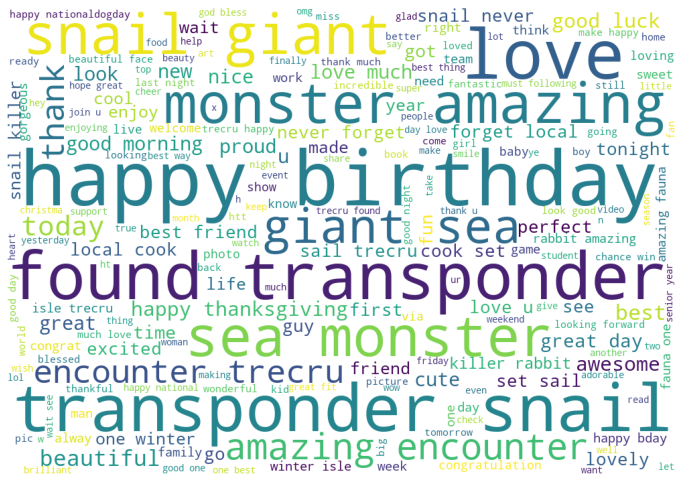

In [26]:
wc = WordCloud(background_color='white', width=1000, height=700)
wc.generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

**Observe from the wordcloud of generic tweets, words with positive sentiment are most frequently related to "happy, birthday, love, amazing, giant, found, transponder, snail, monster, encounter". We should pay attention to those words like transponder, snail, monster because they may be some trending topics during that certain time period and are not actualy representative to our election prediction. It may cause some bias to the results.**

# 3. Model Preparation

### 3.1 Splitting training and test data
We split the generic tweets randomly into training data (70%) and test data (30%).    
The target value y is the column 'label' in sentiment_analysis.csv.

In [27]:
# split 70% training and 30% test data
y= sentiment_df['label']
x_train, x_test, y_train, y_test = train_test_split(sentiment_df['text'], y, test_size = 0.30, random_state = 42)


### 3.2 Features: bag of word
1) We use the CountVectorizer fit on training data.         
2) We add parameter min_df to filter some words that are too uniqe, e.g. tweeter users' name. Otherwise, we would have about 200,000 features.  

Finally we have total 550,391 samples and around 1011 features for generic tweets.   
Then we use the vectorizer to transform test data of generic tweets and test data Canadian_elections_2021.

In [28]:
## bag of word: use CountVectorizer
vectorizer = CountVectorizer(min_df=0.001, stop_words=stopwords.words('english'))

# fit on training data
x_train_bow = vectorizer.fit_transform(x_train)

# fit on test data
x_test_bow = vectorizer.transform(x_test)
x_test_can_bow = vectorizer.transform(elections_df['text'])

print(x_train_bow.shape)
print(x_test_bow.shape)
print(x_test_can_bow.shape)

(385273, 1011)
(165118, 1011)
(1002, 1011)


### 3.3 Features: TF-IDF
1) We use the CountVectorizer fit on training data.      
2) We also add parameter min_df to filter some words that are too uniqe, e.g. tweeter users' name. Otherwise, we would have about 200,000 features.  

Finally we have total 550,391 samples and also around 1011 features for generic tweets. (same number of features as BOW)   
Then we use the vectorizer to transform test data of generic tweets and test data Canadian_elections_2021.

In [29]:
# term frequency: use TfidfVectorizer
vectorizer_tf = TfidfVectorizer(min_df=0.001, stop_words=stopwords.words('english'))

# fit on training data
x_train_tf = vectorizer_tf.fit_transform(x_train)

# fit on test data
x_test_tf = vectorizer_tf.transform(x_test)
x_test_can_tf = vectorizer_tf.transform(elections_df['text'])

print(x_train_tf.shape)
print(x_test_tf.shape)
print(x_test_can_tf.shape)

(385273, 1011)
(165118, 1011)
(1002, 1011)


### 3.4 Prepare 7 classification algorithms
Now we've already have the training data and test data from the sentiment_analysis.csv; we will train logistic regression, k-NN, Naive Bayes, SVM, decision trees, Random Forest and XGBoost on the training data.
- using max_iter=1000 in logistic regression to reduce running time
- max_depth=5 of decision tree to reduce complexity of algorithm, save running time
- set kernel='linear' in SVC to reduce running time
- limit the number of trees=10 and max_depth=5 in the random forest

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [31]:
lr = LogisticRegression(max_iter=1000)
tree = DecisionTreeClassifier(criterion='gini',max_depth=5)
knn = KNeighborsClassifier(n_neighbors=5)
svc = svm.SVC(kernel='linear')
forest = RandomForestClassifier(n_estimators=10,max_depth=5)
bayes = MultinomialNB()
xgboost = XGBClassifier(objective='reg:logistic',use_label_encoder=False)

# 4. Model implement and tuning

### 4a) two types of features & 7 models
Using both types of features (Bag of Words and TF-IDF), train models on the training data from generic tweets and apply the model to the test data of generic tweets to obtain an accuracy value and f1 score. We prepare the normalized dataset as well in case need to use them in the future.   


In [32]:
# in case need to standardize the features
x_train_bow_std = normalize(x_train_bow, axis=0)
x_test_bow_std = normalize(x_test_bow, axis=0)
x_test_can_bow_std = normalize(x_test_can_bow, axis=0)

x_train_tf_std = normalize(x_train_tf, axis=0)
x_test_tf_std = normalize(x_test_tf, axis=0)
x_test_can_tf_std = normalize(x_test_can_tf, axis=0)


In [33]:
# no normalize
#1) LogisticRegression bow & tf-idf
# identify the target values of test data
y_test_can = elections_df['label']

# record all the training and test scores
train_score_acc_bow = []
test_score_acc_bow = []
test_f1_bow = []

train_score_acc_tf = []
test_score_acc_tf = []
test_f1_tf = []

#bow
lr_1 = lr.fit(x_train_bow, y_train)

# predict on train and test set bow
y_train_predict = lr_1.predict(x_train_bow)
y_test_predict = lr_1.predict(x_test_bow)

# calculate train and test accuracy bow
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)
f1 = f1_score(y_test,y_test_predict)
train_score_acc_bow.append(train_accuracy)
test_score_acc_bow.append(test_accuracy)
test_f1_bow.append(f1)


#tfidf
lr_2 = lr.fit(x_train_tf, y_train)
y_train_predict = lr_2.predict(x_train_tf)
y_test_predict = lr_2.predict(x_test_tf)
train_score_acc_tf.append(accuracy_score(y_train, y_train_predict))
test_score_acc_tf.append(accuracy_score(y_test, y_test_predict))
test_f1_tf.append(f1_score(y_test,y_test_predict))


In [34]:
#no normalize
#2) DecisionTreeClassifier bow & tf-idf
#bow
tree_1 = tree.fit(x_train_bow, y_train)

# predict on train and test set bow
y_train_predict = tree_1.predict(x_train_bow)
y_test_predict = tree_1.predict(x_test_bow)

# calculate train and test accuracy bow
train_score_acc_bow.append(accuracy_score(y_train, y_train_predict))
test_score_acc_bow.append(accuracy_score(y_test, y_test_predict))
test_f1_bow.append(f1_score(y_test,y_test_predict))

#tfidf
tree_2 = tree.fit(x_train_tf, y_train)
y_train_predict = tree_2.predict(x_train_tf)
y_test_predict = tree_2.predict(x_test_tf)
train_score_acc_tf.append(accuracy_score(y_train, y_train_predict))
test_score_acc_tf.append(accuracy_score(y_test, y_test_predict))
test_f1_tf.append(f1_score(y_test,y_test_predict))

In [35]:
# no normalize
#3) RandomForestClassifier bow & tf-idf
#bow
forest_1 = forest.fit(x_train_bow, y_train)

# predict on train and test set bow
y_train_predict = forest_1.predict(x_train_bow)
y_test_predict = forest_1.predict(x_test_bow)

# calculate train and test accuracy bow
train_score_acc_bow.append(accuracy_score(y_train, y_train_predict))
test_score_acc_bow.append(accuracy_score(y_test, y_test_predict))
test_f1_bow.append(f1_score(y_test,y_test_predict))

#tfidf
forest_2 = forest.fit(x_train_tf, y_train)
y_train_predict = forest_2.predict(x_train_tf)
y_test_predict = forest_2.predict(x_test_tf)
train_score_acc_tf.append(accuracy_score(y_train, y_train_predict))
test_score_acc_tf.append(accuracy_score(y_test, y_test_predict))
test_f1_tf.append(f1_score(y_test,y_test_predict))

In [36]:
#no normalize
#4) MultinomialNB bow & tf-idf not using standardization
#bow
bayes_1 = bayes.fit(x_train_bow, y_train)

# predict on train and test set bow
y_train_predict = bayes_1.predict(x_train_bow)
y_test_predict = bayes_1.predict(x_test_bow)

# calculate train and test accuracy bow
train_score_acc_bow.append(accuracy_score(y_train, y_train_predict))
test_score_acc_bow.append(accuracy_score(y_test, y_test_predict))
test_f1_bow.append(f1_score(y_test,y_test_predict))

#tfidf
bayes_2 = bayes.fit(x_train_tf, y_train)
y_train_predict = bayes_2.predict(x_train_tf)
y_test_predict = bayes_2.predict(x_test_tf)
train_score_acc_tf.append(accuracy_score(y_train, y_train_predict))
test_score_acc_tf.append(accuracy_score(y_test, y_test_predict))
test_f1_tf.append(f1_score(y_test,y_test_predict))

In [37]:
# no normalize
#5) xgboost bow & tf-idf
#bow
xgboost_1 = xgboost.fit(x_train_bow, y_train)

# predict on train and test set bow
y_train_predict = xgboost_1.predict(x_train_bow)
y_test_predict = xgboost_1.predict(x_test_bow)

# calculate train and test accuracy bow
train_score_acc_bow.append(accuracy_score(y_train, y_train_predict))
test_score_acc_bow.append(accuracy_score(y_test, y_test_predict))
test_f1_bow.append(f1_score(y_test,y_test_predict))

#tfidf
xgboost_2 = xgboost.fit(x_train_tf, y_train)
y_train_predict = xgboost_2.predict(x_train_tf)
y_test_predict = xgboost_2.predict(x_test_tf)
train_score_acc_tf.append(accuracy_score(y_train, y_train_predict))
test_score_acc_tf.append(accuracy_score(y_test, y_test_predict))
test_f1_tf.append(f1_score(y_test,y_test_predict))

In [38]:
# no normalize
#6) KNeighborsClassifier bow & tf-idf
#bow
knn_1 = knn.fit(x_train_bow, y_train)

# predict on train and test set bow
y_train_predict = knn_1.predict(x_train_bow)
y_test_predict = knn_1.predict(x_test_bow)

# calculate train and test accuracy bow
train_score_acc_bow.append(accuracy_score(y_train, y_train_predict))
test_score_acc_bow.append(accuracy_score(y_test, y_test_predict))
test_f1_bow.append(f1_score(y_test,y_test_predict))

#tfidf
knn_2 = knn.fit(x_train_tf, y_train)
y_train_predict = knn_2.predict(x_train_tf)
y_test_predict = knn_2.predict(x_test_tf)
train_score_acc_tf.append(accuracy_score(y_train, y_train_predict))
test_score_acc_tf.append(accuracy_score(y_test, y_test_predict))
test_f1_tf.append(f1_score(y_test,y_test_predict))

In [39]:
# no normalize
#7) SVC bow & tf-idf
#bow
svc_1 = svc.fit(x_train_bow, y_train)

# predict on train and test set bow
y_train_predict = svc_1.predict(x_train_bow)
y_test_predict = svc_1.predict(x_test_bow)

# calculate train and test accuracy bow
train_score_acc_bow.append(accuracy_score(y_train, y_train_predict))
test_score_acc_bow.append(accuracy_score(y_test, y_test_predict))
test_f1_bow.append(f1_score(y_test,y_test_predict))

#tfidf
svc_2 = svc.fit(x_train_tf, y_train)
y_train_predict = svc_2.predict(x_train_tf)
y_test_predict = svc_2.predict(x_test_tf)
train_score_acc_tf.append(accuracy_score(y_train, y_train_predict))
test_score_acc_tf.append(accuracy_score(y_test, y_test_predict))
test_f1_tf.append(f1_score(y_test,y_test_predict))

In [40]:
# put scores of 7 models & 2types of features all together in a dataframe
models = ['LogisticRegression', 'DecisionTree','RandomForest','MultinomialNB','Xgboost','KNN','SVC']
final_scores = pd.DataFrame({'Train accuracy of BOW': train_score_acc_bow, 'Train accuracy of TFIDF':train_score_acc_tf,
                        'Test accuracy of BOW': test_score_acc_bow, 'Test accuracy of TFIDF':test_score_acc_tf,
                        'Test F1 score of BOW': test_f1_bow, 'Test F1 score of TFIDF': test_f1_tf}, index=models).sort_values(by='Test F1 score of BOW')
final_scores

,Train accuracy of BOW,Train accuracy of TFIDF,Test accuracy of BOW,Test accuracy of TFIDF,Test F1 score of BOW,Test F1 score of TFIDF
SVC,0.653541,0.643219,0.641294,0.643195,0.759762,0.768635
DecisionTree,0.675189,0.675212,0.674984,0.675002,0.805835,0.805838
RandomForest,0.678555,0.677195,0.678503,0.677061,0.807520,0.806877
KNN,0.720755,0.590788,0.700145,0.571249,0.812384,0.681573
MultinomialNB,0.897821,0.887750,0.897479,0.888098,0.925960,0.921304
Xgboost,0.922035,0.922865,0.921493,0.921474,0.939510,0.939516
LogisticRegression,0.940006,0.939160,0.939667,0.938735,0.954736,0.954225


### 4a)-a. Choose the model with the best performance
We want to compare the 14 models (7 algorithms * 2 types of features) mainly based on accuracy and F1 scores of the test dataset.   

Notice that the results between bag of word and tf-idf are almost very similar, difference is about 0.1%; except the score difference is relatively large between those two types of features under the KNN model.

We observed that the model logistic regression with bag-of word feature has the highest test accuracy score=93.97% and the F1 score=95.47%. Other models such as the XgBoost and multinomial naive bayes also perform well. Those  models have relatively high training and testing accuracies > 85%.

Finally, we choose the logistic regression algorithm with bag-of word feature on the Canadian Elections data.

In [41]:
y_test_can = elections_df['label']
# fit on dataset without normalization
lr_1 = lr.fit(x_train_bow, y_train)

# predict on test set bow
y_test_predict = lr_1.predict(x_test_can_bow)

# calculate test accuracy bow

print("Logistic Reg with BOW's test accuracy score:",accuracy_score(y_test_can, y_test_predict))
print("Logistic Reg with BOW's test F1 score:",f1_score(y_test_can,y_test_predict))

Logistic Reg with BOW's test accuracy score: 0.687624750499002
Logistic Reg with BOW's test F1 score: 0.7004784688995215


In [42]:
y_test_can = elections_df['label']
# fit on dataset with normalization
lr_1 = lr.fit(x_train_bow_std, y_train)

# predict on test set bow
y_test_predict = lr_1.predict(x_test_can_bow_std)

# calculate test accuracy bow

print("Logistic Reg with BOW's (normalize) test accuracy score:",accuracy_score(y_test_can, y_test_predict))
print("Logistic Reg with BOW's (normalize) test F1 score:",f1_score(y_test_can,y_test_predict))

Logistic Reg with BOW's (normalize) test accuracy score: 0.7285429141716567
Logistic Reg with BOW's (normalize) test F1 score: 0.7667238421955402


**Evaluate the trained model with the best performance on the Canadian Elections data as above. If we use the test accuracy score to interpret the predictions match of the sentiment labels and do not normalize the data, we find the match is around 68.76% (F1 score is higher 70.48%). If we normalize the training and test data, the accuracy score is improved to 72.85% (F1 score 76.67%). Overall, the score is acceptable.**

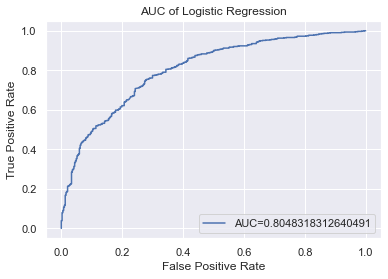

In [43]:
# AUC of logistic regression
from sklearn import metrics
y_pred_proba = lr_1.predict_proba(x_test_can_bow_std)[::,1]
fpr, tpr,_ = metrics.roc_curve(y_test_can,y_pred_proba)
auc = metrics.roc_auc_score(y_test_can,y_pred_proba)

plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.title('AUC of Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

### 4a)-b. Two other metrics
(We observed imbalanced data among 4 political parties.)   

We could choose to use the **precision score** which predicts the positive sentiments out of all the positive predictions. It's useful for the political parties and election team because they could get broad sense of knowing how many potential voters for the election candidate. Also if we'd like to make predictions among 4 political parties, the precision is useful since the classes are very imbalanced in this case.  

We could also choose the **recall score** which focuses on the true positive-sentiment class, predicting the positives out of actual positives. It could provide more precise indication than the precision score. Because the election team is able to identify all actual supporters out of all positive sentiments that exist within the dataset. The higher recall score means the better the model is at identifying both positive and negative sentiments. Also, recall score is useful when classes are very imbalanced.

### 4a)-c. visualize sentiment predictions of 4 parties

For each tweet, we count the frequencies of each party's key words respectively. For example, the key words belong to the liberal party occur the most often, then we classify the tweet into the liberal political party. If the occurence of all four-type key words is 0, we say the tweet belongs to none of the parties. Overall, each tweet can only be assigned with one party label.

In [55]:
# each party's key words
lib = ['liberal','relentless','justintrudeau','trudeau','justin']
cons = ['conservative','toole','otoole','trudeau','erin','cpc']
ndp = ['ndp','newdemocratic','democratic','jagmeetsingh','jagmeet','singh']
ppc = ['ppc','peoplespca','maximebernier','bernier','maxime']
name=['liberal','conservative','NDP','PPC']
party=[]

for i in range(len(elections_df)):
    total=[]
    a=0
    b=0
    c=0
    d=0
    for key in lib:
        a += elections_df.text[i].count(key)
    total.append(a)

    for key in cons:
        b+= elections_df.text[i].count(key)
    total.append(b)

    for key in ndp:
        c+= elections_df.text[i].count(key)
    total.append(c)

    for key in ppc:
        d+= elections_df.text[i].count(key)
    total.append(d)

    if max(total) != 0:
        party.append(name[np.argmax(total)])
    
    else:
        party.append('None')

elections_df['prediction']=y_test_predict
elections_df['Party']=pd.Series(party)

In [56]:
# check prediction match: correct/wrong for each tweet
true_false=[]
for i in range(len(elections_df)):
    if elections_df.label[i]==elections_df.prediction[i]:
        true_false.append('correct prediction')
    
    else:
        true_false.append('incorrect prediction')

elections_df['prediction match']=pd.Series(true_false)        

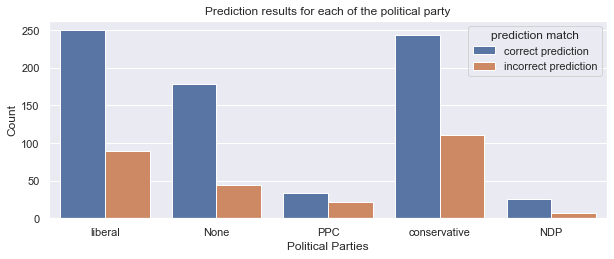

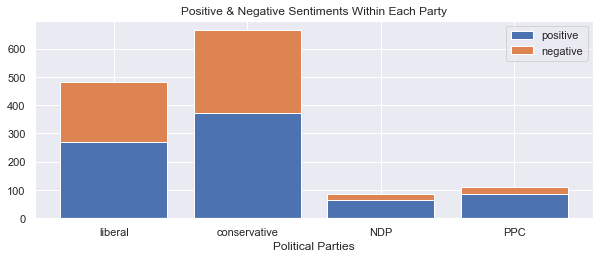

In [57]:
# visualize the sentiment prediction results and the true sentiment for each of the 4 parties
sns.set()
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
sns.countplot(x='Party',hue='prediction match', data = elections_df)
plt.title('Prediction results for each of the political party')
plt.ylabel('Count')
plt.xlabel('Political Parties')
plt.show()

# how each party is viewed in the public eye based on the sentiment value
plt.figure(figsize=(10, 8))
ax = plt.subplot(2,1,2)
ax.bar(parties_name, party_sentiment.positive, tick_label=parties_name, label='positive')
ax.bar(parties_name, party_sentiment.negative, bottom=party_sentiment.positive, label='negative')
plt.legend()
plt.title('Positive & Negative Sentiments Within Each Party')
plt.xlabel('Political Parties')
plt.show()

Figure "Prediction results for each of the political party":    
It seems like **the NLP analytics is useful** for election campaigns especially if the political party is controversial online, so that we can have enough tweet data to do training analysis. For liberal and conservative parties, the number of correct predictions of sentiment is two to three times larger than the number of incorrect predictions. The numbers of correct predictions are also good for NDP. However, since few tweets are related to the party PPC and NDP, the NLP analytics may not be that meaningful for them to utilize. Also, some part of tweets cannot be classified into specific parties, the prediction results may not be useful as well. Overall, the accuracy is around 70%, thus, we could say that the NLP analytics is useful to especially liberal and conservative parties. 


Recall the plot during EDA, **in the public eye based on the sentiment value**, more people were talking about the conservative party, and both liberal and conservative have around 55% positive-sentiment and 45% negative-sentiment tweets. Thus, the numbers of supports and criticisms are quite similar for liberal and conservative. On the other hand, less total expressed sentiments on NDP and PPC 



**To improve the accuracy of this model**, we can further do the hyperparameter tuning on the logistic regression, or even on the 14 models (though it would take lots of time). For hyperparameter tuning of logistic regression, we can tune the regularization strength C, the type of solver, the type of penalty and etc. Also, to improve the accuracy among the four political parties, we could find a better way to classify the tweets into different political parties. For now, we just count the frequency of distinct party's key words in each tweet. Also, if two parties' frequencies are the same, we randomly choose the party that first appeared. For improvement, maybe we could duplicate the tweet if two parties' frequencies are the same.

### 4b) Choose decision tree

negative reasons: ['calling election early' 'covid ' 'others' 'scandal' 'tell lies'
 'gun control' 'economy' 'healthcare and marijuana' 'segregation'
 'women reproductive right and racism' 'climate problem']


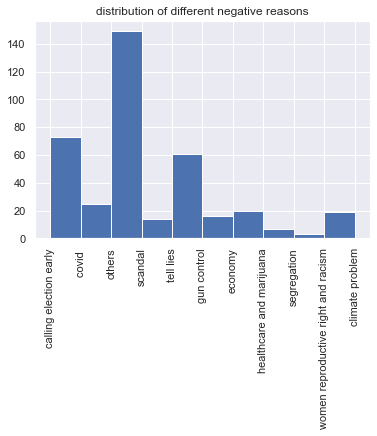

In [58]:
# prepare negative Canadian elections tweets
elections_neg_df = elections_df[elections_df['label']==0]
elections_neg_df = elections_neg_df.drop(['prediction', 'prediction match'], axis=1)
print('negative reasons:', elections_neg_df['negative_reason'].unique())


#check on distribution of different negative reasons
plt.hist(elections_neg_df.negative_reason)
plt.title('distribution of different negative reasons')
plt.xticks(rotation=90)
plt.show()

# encode the target into integer values
# put scandal and tell lies as one category
elections_neg_df.loc[elections_neg_df['negative_reason']=='others','negative_reason'] = 0
elections_neg_df.loc[elections_neg_df['negative_reason']=='calling election early','negative_reason'] = 1
elections_neg_df.loc[elections_neg_df['negative_reason']=='covid ','negative_reason'] = 2
elections_neg_df.loc[elections_neg_df['negative_reason']=='scandal','negative_reason'] = 3
elections_neg_df.loc[elections_neg_df['negative_reason']=='tell lies','negative_reason'] = 3
elections_neg_df.loc[elections_neg_df['negative_reason']=='gun control','negative_reason'] = 4
elections_neg_df.loc[elections_neg_df['negative_reason']=='economy','negative_reason'] = 5
elections_neg_df.loc[elections_neg_df['negative_reason']=='healthcare and marijuana','negative_reason'] = 6
elections_neg_df.loc[elections_neg_df['negative_reason']=='segregation','negative_reason'] = 7
elections_neg_df.loc[elections_neg_df['negative_reason']=='women reproductive right and racism','negative_reason'] = 8
elections_neg_df.loc[elections_neg_df['negative_reason']=='climate problem','negative_reason'] = 9


In [59]:
# split 70% training and 30% test data
y= elections_neg_df['negative_reason']
x_train, x_test, y_train, y_test = train_test_split(elections_neg_df['text'], y, test_size = 0.30, random_state = 42)

# build features-BOW
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
x_train_neg = vectorizer.fit_transform(x_train)
x_test_neg = vectorizer.transform(x_test)
print(x_train_neg.shape)
print(x_test_neg.shape)

(270, 1853)
(117, 1853)


In [60]:
# choose the decision tree classifer as the model
from sklearn.model_selection import GridSearchCV
tree = DecisionTreeClassifier()

# hyperparameter tuning
params = {'max_depth': [2, 3, 5, 10, 15, 20],
          'min_samples_leaf': [10, 20, 50, 100, 200],
          'criterion':['gini','entropy']}

grid = GridSearchCV(estimator=tree, param_grid=params, cv=5, n_jobs=-1, scoring = "accuracy")
grid.fit(x_train_neg,y_train.astype(int))

print(grid.best_estimator_)
print(grid.best_score_)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


DecisionTreeClassifier(max_depth=3, min_samples_leaf=20)
0.4962962962962963


After we tune the hyperparameters max_depth, min_samples_leaf, criterion of decision tree classifier, we get the best estimator DecisionTreeClassifier(max_depth=3, min_samples_leaf=20, criterion='entropy') with the best socre. Then we test prediction reason on testing data.

In [61]:
# make predictions on testing data
tree_best= DecisionTreeClassifier(max_depth=3, min_samples_leaf=20, criterion='entropy')
tree_best = tree_best.fit(x_train_neg,y_train.astype(int))

predict_reason = tree_best.predict(x_test_neg)
print('Accuracy score for prediction negative reason:', accuracy_score(y_test.astype(int),predict_reason))
print('F1 score for prediction negative reason:', f1_score(y_test.astype(int),predict_reason, average='weighted'))

Accuracy score for prediction negative reason: 0.4358974358974359
F1 score for prediction negative reason: 0.2976559460075943


### 4b)-a.
When the multi-class model above is trying to predict the correct negative reasons, it gets accuracy acore 43.59% and f1 score 29.77% which both are relatively low. It may fail mainly because:   
- Overall the dataset upon negative reasons is relatively small. We have 270 samples of training data and 117 samples of test data, but have 1696 features. Thus, we do not have enough data to do the training.    

- Due to the insufficient data, the number of samples in some category (target value) is limited to do the n_splits cross-validation.

- The target value - negative reasons are unevenly distributed, for eample in the test data, reasons of calling election early, others, and telling lies have higher number of samples, while other reasons have much less samples.


### 4b)-b.
To improve the accuracy of the selected model, we could mainly get a data set with larger size, not only tweets but also posts from other social medias, i.e. Facebook and comments below the news / article. Otherwise, we may could try word embedding to build features which have a better understanding on the sequence of words.    


### 4b)-c.
Notice that we combine 'tell lies' and 'scandal' with the same target encoding as the one reason. Because we find these two are quite similar, having a scandal usually means doing something morally or legally wrong and telling lies can be a part of that. Also, we hope the integration can mitigate the imbalance of dataset.   

Also notice that we define input features using word frequency analysis (bag of words) from CountVectorizer.

### 4c)
Use the frequency of the words (Bag of Words) to rank the top-50 most frequent non-stop words in the Canadian elections dataset, for (i) positive and (ii) negative tweets seperately. 

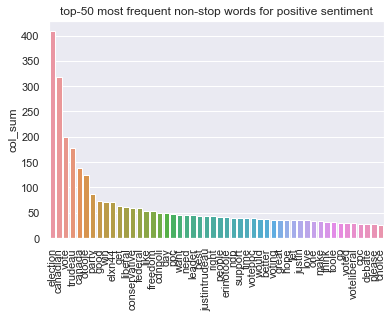

Index(['election', 'canadian', 'vote', 'trudeau', 'canada', 'otoole', 'party',
       'good', 'win', 'elxn44', 'get', 'liberal', 'conservative', 'federal',
       'like', 'freedom', 'cdnpoli', 'day', 'ppc', 'want', 'need', 'leader',
       'best', 'justintrudeau', 'right', 'people', 'erinotoole', 'ndp',
       'support', 'time', 'voteppc', 'would', 'better', 'voting', 'great',
       'hope', 'let', 'justin', 'love', 'one', 'make', 'think', 'toole', 'go',
       'voted', 'voteliberal', 'cpc', 'debate', 'please', 'choice'],
      dtype='object')


In [62]:
# (i) positive - truth sentiment
positive_df = elections_df[elections_df['label']==1]

# bag of words
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
positive = vectorizer.fit_transform(positive_df['text'])
pos = pd.DataFrame(positive.toarray(),columns=vectorizer.get_feature_names())

# rank the word frequency in descending order and pick the top 50
pos=pos.reindex(columns=pos.sum().sort_values(ascending=False).index)
pos = pos.iloc[:,:50]
pos.loc['col_sum']=pos.apply(lambda x: x.sum())

# plot the top 50
a = pd.DataFrame(pos.loc['col_sum'],index=pos.columns)
sns.barplot(x=pos.columns, y=a.col_sum)
plt.xticks(rotation=90)
plt.title('top-50 most frequent non-stop words for positive sentiment')
plt.show()

# print the 50 non-stop words
print(pos.columns)

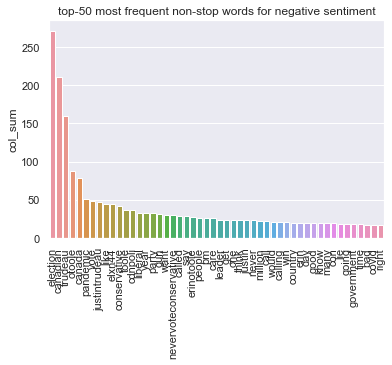

Index(['election', 'canadian', 'trudeau', 'otoole', 'canada', 'pandemic',
       'vote', 'justintrudeau', 'like', 'elxn44', 'conservative', 'toole',
       'cdnpoli', 'liberal', 'year', 'party', 'gun', 'want',
       'nevervoteconservative', 'called', 'say', 'erinotoole', 'people', 'pm',
       'care', 'leader', 'get', 'one', 'think', 'justin', 'never', 'million',
       'call', 'would', 'calling', 'win', 'country', 'erin', 'day', 'good',
       'know', 'many', 'con', 'lie', 'going', 'government', 'time', 'bad',
       'covid', 'right'],
      dtype='object')


In [63]:
# (ii) negative - truth sentiment
negative_df = elections_df[elections_df['label']==0]

# bag of words
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
negative = vectorizer.fit_transform(negative_df['text'])
neg = pd.DataFrame(negative.toarray(),columns=vectorizer.get_feature_names())

# rank the word frequency in descending order and pick the top 50
neg=neg.reindex(columns=neg.sum().sort_values(ascending=False).index)
neg = neg.iloc[:,:50]
neg.loc['col_sum']=neg.apply(lambda x: x.sum())

# plot the top 50
b = pd.DataFrame(neg.loc['col_sum'],index=neg.columns)
sns.barplot(x=neg.columns, y=b.col_sum)
plt.xticks(rotation=90)
plt.title('top-50 most frequent non-stop words for negative sentiment')
plt.show()

# print the 50 non-stop words
print(neg.columns)

### 4c)  discuss finding:
We find that for both of the positive and negative sentiments, the top 50 most frequent non-stop words include election, canadian, trudeau, canada, otoole, vote, party, government, and care. Those words are relatively neutral. Since some coincidences occur in those two sentiment groups, it may add difficulty to make a classification on that.     

On the other hand, it makes sense that positive-sentiment group contains such words, like good, win, freedom, best, right, support, better, great, and hope. It also make sense that negative-sentiment group contains such words, like never, gun, lie, bad, and unnecessary.   

Overall, if the distinction between top 50 words of positive sentiment and negative sentiment could be more clearer, we would have a higher accuracy in the prediction.

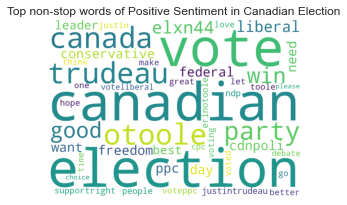

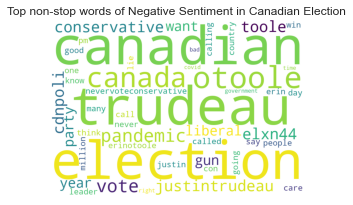

In [64]:
all_text = pd.Series(pos.columns).str.cat(sep=' ')
wc = WordCloud(background_color='white', width=1000, height=700)
wc.generate(all_text)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('Top non-stop words of Positive Sentiment in Canadian Election')
plt.imshow(wc)
plt.axis("off")
plt.show()

all_text = pd.Series(neg.columns).str.cat(sep=' ')
wc = WordCloud(background_color='white', width=1000, height=700)
wc.generate(all_text)
plt.figure(figsize=(10,10))
plt.subplot(1,2,2)
plt.title('Top non-stop words of Negative Sentiment in Canadian Election')
plt.imshow(wc)
plt.axis("off")
plt.show()